In [2]:
import pickle as pk
from imdb_indexer import word2index
import numpy as np
import pandas as pd
import itertools
import os
from functions import make_ngram, uptoNgram
import tqdm
import matplotlib.pyplot as plt
from bow import BagOfWords, test_model


In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset

class IMDbDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [4]:
ngram_dct = pk.load(open("ngram_dct.pk", "rb"))
ngram_dct_nltk = pk.load(open("ngram_dct_nltk.pk", "rb"))
train_label = pk.load(open("train_label.pk", "rb"))
test_label = pk.load(open("test_label.pk", "rb"))
val_label = pk.load(open("val_label.pk", "rb"))


## setting: unigram, vocab_size = , emb_size = , adam optimizer, learning rate = 

In [5]:
max_vocab_size = 20000
learning_rate = 0.005
learning_rate_decay = False
num_epochs = 10
emb_dim = 300

In [6]:
val_curve_tokscheme = []
val_acc_tokscheme = []

In [1]:
#spacy tokenization

In [7]:
train_features = ngram_dct['train_1']
val_features = ngram_dct['val_1']
test_features = ngram_dct['test_1']

PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)
MAX_SENTENCE_LENGTH = 200

# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = IMDbDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)


model = BagOfWords(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
val_acc_list = []
for epoch in tqdm.trange(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        val_acc = test_model(val_loader, model)
        optimizer.step()

    val_acc_list.append(val_acc)
    if learning_rate_decay == True:
        scheduler.step(val_acc)


val_curve_tokscheme.append(val_acc_list)
val_acc_tokscheme.append(test_model(val_loader, model))
print('finish spacy tokenization, val_acc: %s' %(test_model(val_loader, model)))

100%|██████████| 10/10 [39:34<00:00, 237.46s/it]


finish spacy tokenization, val_acc: 85.06


In [8]:
#nltk tokenization 
train_features = ngram_dct_nltk['train_1']
val_features = ngram_dct_nltk['val_1']
test_features = ngram_dct_nltk['test_1']

PAD_IDX = 0
UNK_IDX = 1
all_train_features = list(itertools.chain.from_iterable(train_features))

builder = word2index(PAD_IDX, UNK_IDX)
#build vocab
token2id, id2token = builder.build_vocab(all_train_features, max_vocab_size)
train_data_indices = builder.token2index_dataset(train_features)
val_data_indices = builder.token2index_dataset(val_features)
test_data_indices = builder.token2index_dataset(test_features)
MAX_SENTENCE_LENGTH = 200

# create pytorch dataloader
BATCH_SIZE = 64
train_dataset = IMDbDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDbDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = IMDbDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

model = BagOfWords(len(id2token), emb_dim)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
val_acc_list = []
for epoch in tqdm.trange(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        val_acc = test_model(val_loader, model)
        optimizer.step()

    val_acc_list.append(val_acc)
    if learning_rate_decay == True:
        scheduler.step(val_acc)


val_curve_tokscheme.append(val_acc_list)
val_acc_tokscheme.append(test_model(val_loader, model))
print('finish nltk tokenization, val_acc: %s' %(test_model(val_loader, model)))

100%|██████████| 10/10 [54:07<00:00, 324.75s/it]


finish nltk tokenization, val_acc: 85.74


Text(0.5,1,'unigram, adam optimization (lr=0.005), embedding_dim = 300')

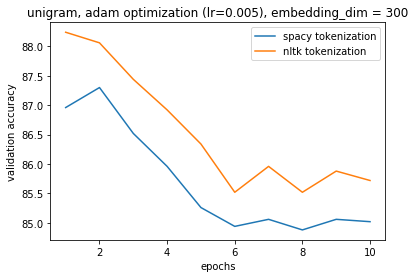

In [10]:
plt.plot(np.arange(1,num_epochs+1), val_curve_tokscheme[0], label = 'spacy tokenization' )
plt.plot(np.arange(1,num_epochs+1), val_curve_tokscheme[1], label = 'nltk tokenization' )
plt.legend()
plt.ylabel('validation accuracy')
plt.xlabel('epochs')
plt.title('unigram, adam optimization (lr=%s), embedding_dim = %s'%(learning_rate, emb_dim))